In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
def load_data():
    # Parse the 'Dates' column as datetime and set as index directly
    aapl_X_train = pd.read_csv('../../data/input_data_splits/aapl_X_train.csv', parse_dates=['Date'], index_col='Date')
    aapl_X_dev = pd.read_csv('../../data/input_data_splits/aapl_X_dev.csv', parse_dates=['Date'], index_col='Date')
    aapl_X_test = pd.read_csv('../../data/input_data_splits/aapl_X_test.csv', parse_dates=['Date'], index_col='Date')

    # For Y sets, if they don't have 'Dates' column, just load them normally:
    aapl_y_train = pd.read_csv('../../data/input_data_splits/aapl_y_train.csv')
    aapl_y_dev = pd.read_csv('../../data/input_data_splits/aapl_y_dev.csv')
    aapl_y_test = pd.read_csv('../../data/input_data_splits/aapl_y_test.csv')

    # Drop the first unnamed column if it exists
    aapl_y_train = aapl_y_train.drop(aapl_y_train.columns[0], axis=1)
    aapl_y_dev = aapl_y_dev.drop(aapl_y_dev.columns[0], axis=1)
    aapl_y_test = aapl_y_test.drop(aapl_y_test.columns[0], axis=1)

    # Now, since Y sets align row-by-row with X sets, we can assign the X sets' DatetimeIndex to Y sets
    aapl_y_train.index = aapl_X_train.index
    aapl_y_dev.index = aapl_X_dev.index
    aapl_y_test.index = aapl_X_test.index

    return aapl_y_train, aapl_y_dev, aapl_y_test

aapl_y_train, aapl_y_dev, aapl_y_test = load_data()
aapl_y_train = pd.concat([aapl_y_train, aapl_y_dev], axis=0)
aapl_y = pd.concat([aapl_y_train, aapl_y_test], axis=0)

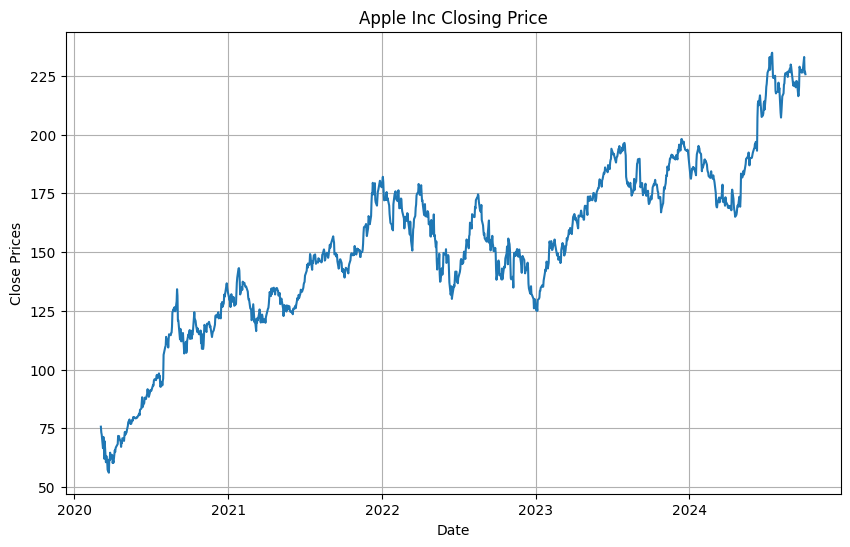

In [3]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(aapl_y['Close'])
plt.title('Apple Inc Closing Price')
plt.show()

<Axes: ylabel='Density'>

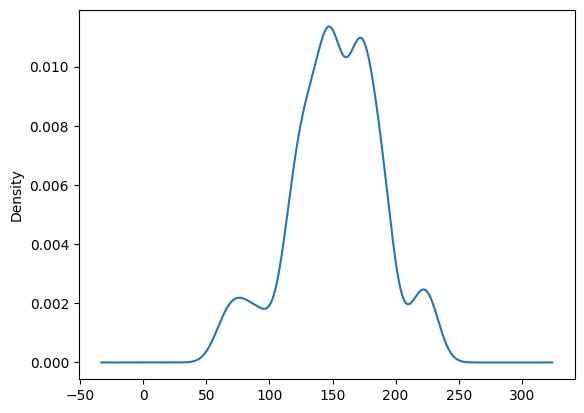

In [4]:
aapl_close = aapl_y['Close']
aapl_close.plot(kind='kde')

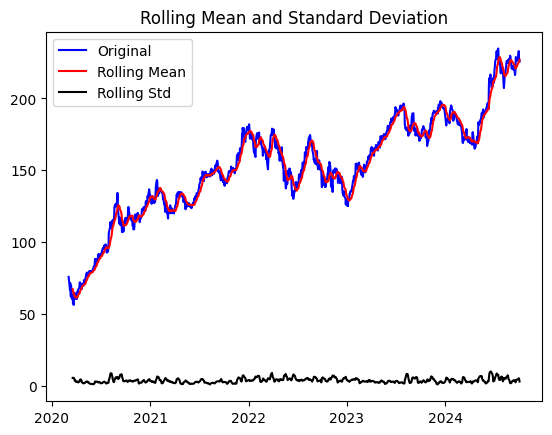

Results of Dickey Fuller Test
Test Statistics                  -1.372972
p-value                           0.595163
No. of lags used                  0.000000
Number of observations used    1154.000000
critical value (1%)              -3.436029
critical value (5%)              -2.864048
critical value (10%)             -2.568105
dtype: float64


In [5]:
def test_stationarity(timeseries):
    # Determining rolling stats
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling stats
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')

    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')

    plt.show(block=False)

    print("Results of Dickey Fuller Test")
    adft = adfuller(timeseries, autolag='AIC')
    # output for dft provides accurate stationarity results without defining what values are

    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, values in adft[4].items():
        output['critical value (%s)'%key] = values
    
    print(output)

test_stationarity(aapl_close)

<Figure size 640x480 with 0 Axes>

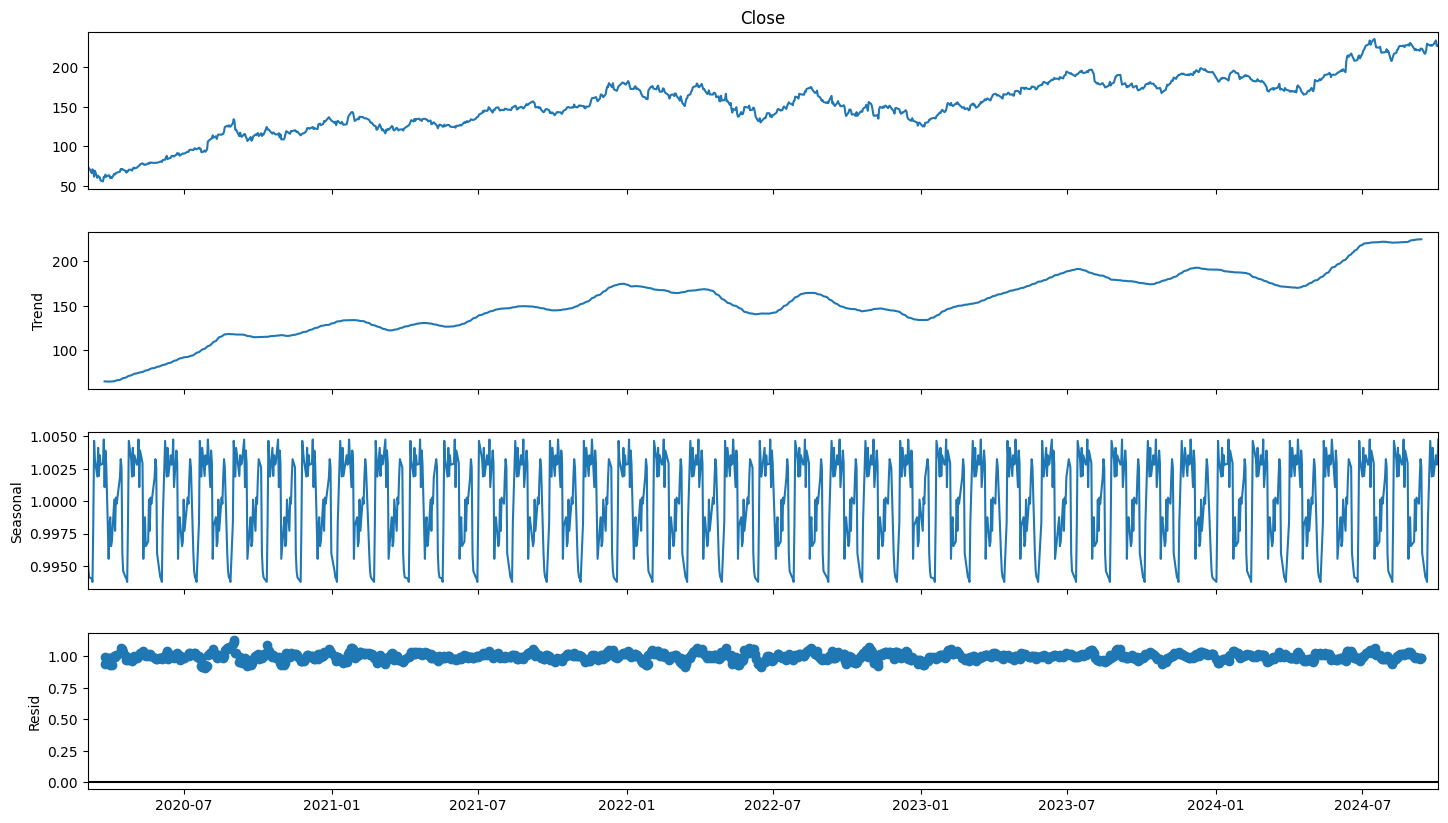

In [6]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(aapl_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

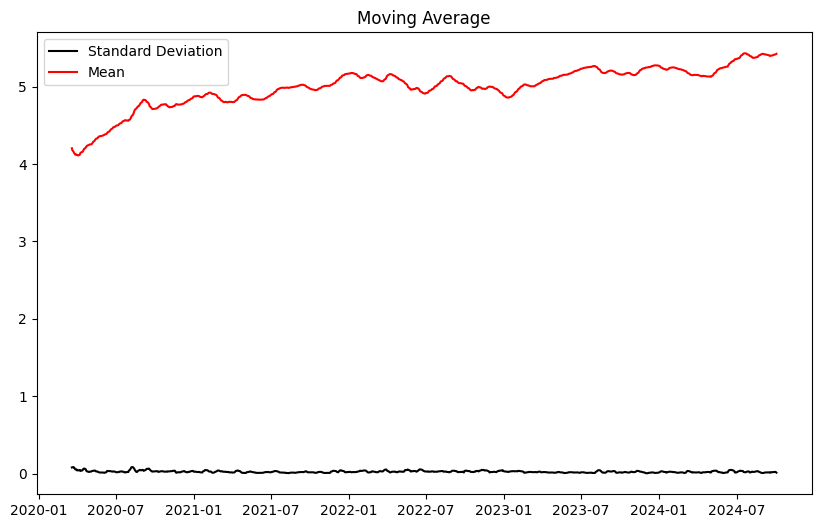

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6


df_log = np.log(aapl_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

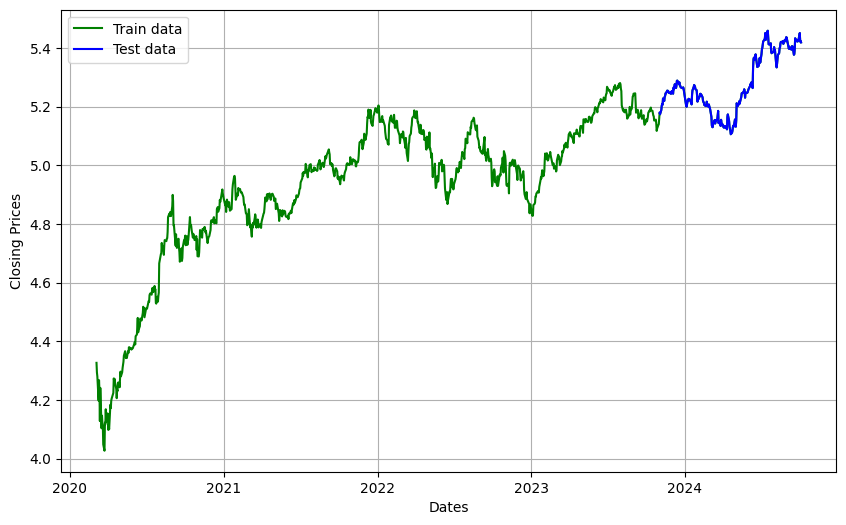

In [8]:
cutoff = df_log.index[int(len(df_log)*0.8)]
train_data = df_log[:cutoff]
test_data = df_log[cutoff:]


plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4492.193, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4505.391, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4504.793, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4492.450, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4503.565, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4503.532, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4501.403, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4505.133, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.910 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  925
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2255.695
Date:                Fri, 13 Dec 2024   AIC                          -4505.391
Time:                       

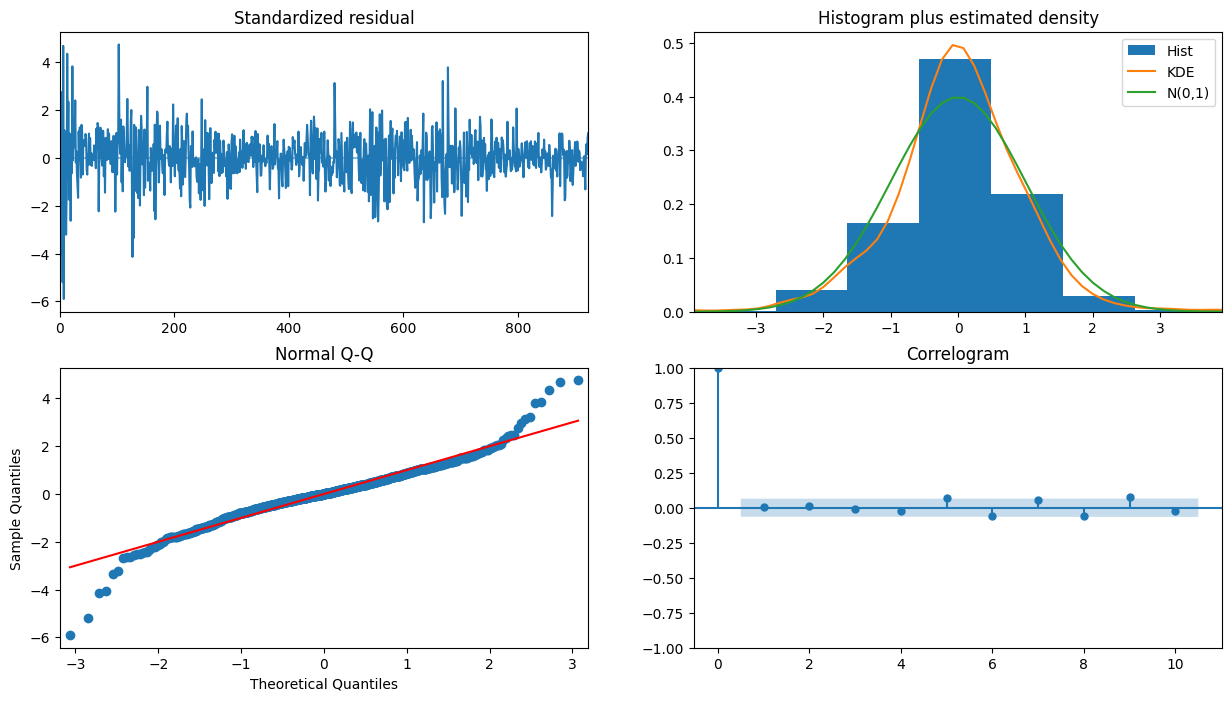

In [9]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [10]:
model = ARIMA(train_data, order = (1, 0, 1))
fitted = model.fit()
print(fitted.summary())

/Users/bobbytomlinson/Desktop/Coding/School/CS 549/financialTrendForecasting/ftfVenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bobbytomlinson/Desktop/Coding/School/CS 549/financialTrendForecasting/ftfVenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/bobbytomlinson/Desktop/Coding/School/CS 549/financialTrendForecasting/ftfVenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  925
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2254.066
Date:                Fri, 13 Dec 2024   AIC                          -4500.132
Time:                        12:54:52   BIC                          -4480.813
Sample:                             0   HQIC                         -4492.761
                                - 925                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.8185      0.254     18.983      0.000       4.321       5.316
ar.L1          0.9986      0.002    568.897      0.000       0.995       1.002
ma.L1         -0.1194      0.022     -5.449      0.0

In [11]:
pred = fitted.get_forecast(steps=len(test_data))
fc = pred.predicted_mean
conf = pred.conf_int(alpha=0.05)

# Make sure forecast series matches test_data index (which is DatetimeIndex)
fc_series = pd.Series(fc.values, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0].values, index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1].values, index=test_data.index)


/Users/bobbytomlinson/Desktop/Coding/School/CS 549/financialTrendForecasting/ftfVenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


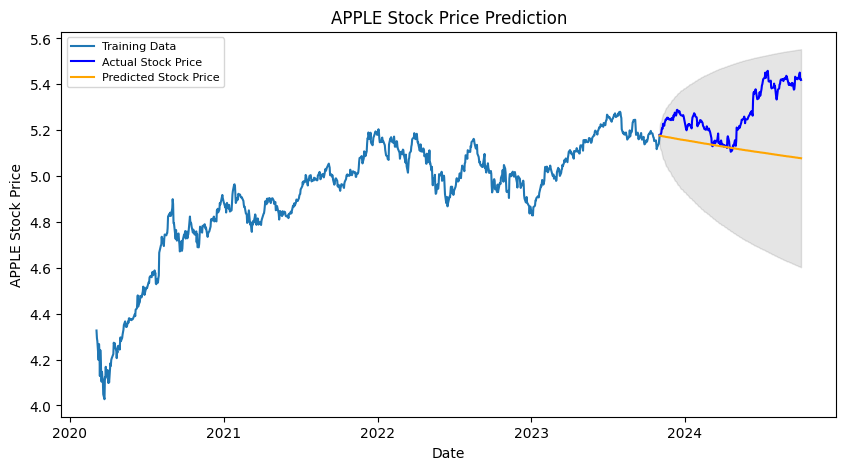

In [12]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(fc_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('APPLE Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('APPLE Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [13]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc_series - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.037835923707222247
MAE: 0.152608499355486
RMSE: 0.1945145848187797
MAPE: 0.02850797832910443


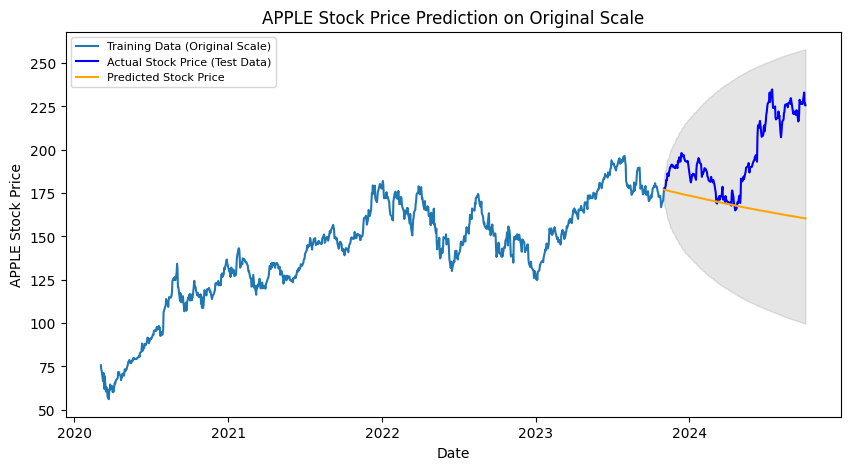

In [14]:
# Convert train and test sets back to original scale without changing their indexes
train_data_exp = np.exp(train_data)
test_data_exp = np.exp(test_data)

# Manually align forecast indices with test_data if the forecast indices are incorrect
fc_series_real = pd.Series(np.exp(fc.values), index=test_data.index)
lower_series_real = pd.Series(np.exp(conf.iloc[:, 0].values), index=test_data.index)
upper_series_real = pd.Series(np.exp(conf.iloc[:, 1].values), index=test_data.index)

# Plot everything on the original scale
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_exp, label='Training Data (Original Scale)')
plt.plot(test_data_exp, color='blue', label='Actual Stock Price (Test Data)')
plt.plot(fc_series_real, color='orange', label='Predicted Stock Price')
plt.fill_between(fc_series_real.index, lower_series_real, upper_series_real, color='k', alpha=0.1)
plt.title('APPLE Stock Price Prediction on Original Scale')
plt.xlabel('Date')
plt.ylabel('APPLE Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [15]:
fc_series_real.to_csv('../../data/final_output_data/aaplARIMApred.csv')